In [1]:
from nsepython import nsefetch
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nsepython import equity_history

In [2]:
# --- Config ---
SYMBOL = "INFY"
MARKET_INDEX = "NIFTY"
END_DATE = datetime(2025, 7, 15)
START_DATE = END_DATE - timedelta(days=365)

In [14]:
# --- Fetch stock data ---
def fetch_data(symbol):
    df = equity_history(
        symbol=symbol,
        series="EQ",
        start_date="15-07-2024",
    end_date = "15-07-2025"
    )
    if df.empty:
        print(f"No data for {symbol}")
        return df
     # Map and rename columns
    df['Date'] = pd.to_datetime(df['CH_TIMESTAMP'])
    df.set_index('Date', inplace=True)
    df = df.sort_index()
    
    df = df.rename(columns={
        'CH_OPENING_PRICE': 'Open',
        'CH_TRADE_HIGH_PRICE': 'High',
        'CH_TRADE_LOW_PRICE': 'Low',
        'CH_CLOSING_PRICE': 'Close',
        'CH_TOT_TRADED_QTY': 'Volume'
    })

    return df[['Open', 'High', 'Low', 'Close', 'Volume']]

stock_df = fetch_data(SYMBOL)

In [15]:
stock_df.columns,stock_df.size

(Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object'), 1280)

In [19]:
# === Technical Indicators ===
df=stock_df.copy()
# Moving Averages
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

# RSI (14)
delta = df['Close'].diff()
gain = delta.clip(lower=0).rolling(window=14).mean()
loss = -delta.clip(upper=0).rolling(window=14).mean()
rs = gain / loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# MACD
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger Bands
mid = df['Close'].rolling(window=20).mean()
std = df['Close'].rolling(window=20).std()
df['BB_Upper'] = mid + 2 * std
df['BB_Lower'] = mid - 2 * std

In [20]:
# === Risk Parameters ===
df['daily_return'] = df['Close'].pct_change()

volatility = df['daily_return'].std() * np.sqrt(252) * 100
var_95 = df['daily_return'].quantile(0.05) * 100
cumulative_return = (df['Close'][-1] / df['Close'][0]) - 1
sharpe_ratio = df['daily_return'].mean() / df['daily_return'].std() * np.sqrt(252)

# Max drawdown
cumulative = (1 + df['daily_return']).cumprod()
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
max_drawdown = drawdown.min() * 100

C:\Users\Utkarsh Ranjan\AppData\Local\Temp\ipykernel_5956\1022369431.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return = (df['Close'][-1] / df['Close'][0]) - 1



=== Risk Parameters ===
Volatility (Annualized):     25.08%
Sharpe Ratio:                -0.17
Cumulative Return:           -7.11%
Max Drawdown:                -30.15%
Value at Risk (95% daily):   -2.82%

=== Sample Data with Indicators ===
             Close    SMA_20    SMA_50       EMA_20       EMA_50     RSI_14  \
Date                                                                          
2025-07-10  1615.8  1616.905  1584.594  1613.168174  1597.283435  47.995483   
2025-07-10  1615.8  1617.595  1586.774  1613.418824  1598.009575  61.505065   
2025-07-11  1594.9  1616.150  1588.500  1611.655126  1597.887631  54.243778   
2025-07-14  1570.3  1612.670  1589.676  1607.716543  1596.805763  34.932432   
2025-07-15  1585.6  1610.305  1591.222  1605.610205  1596.366321  40.628853   

                 MACD  MACD_Signal     BB_Upper     BB_Lower  
Date                                                          
2025-07-10  12.608247    13.188370  1650.329698  1583.480302  
2025-07-10  11.

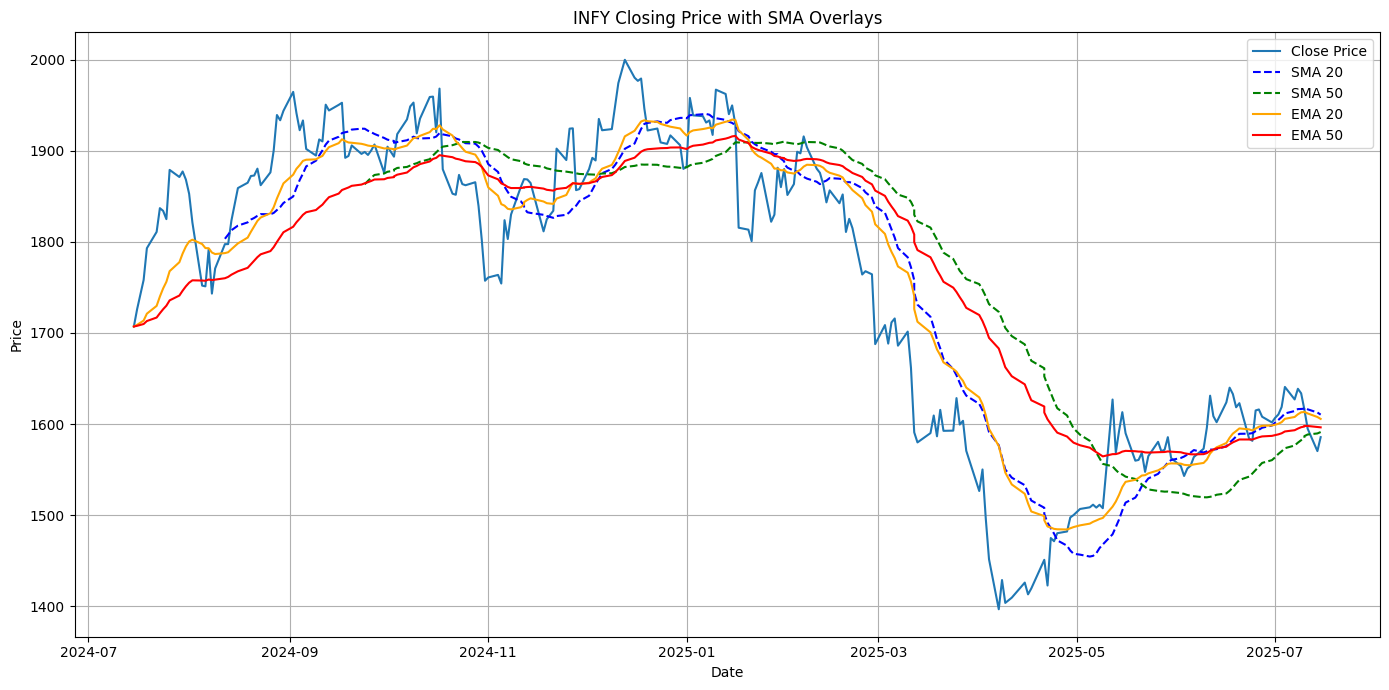

In [21]:
# === Output ===
print("\n=== Risk Parameters ===")
print(f"Volatility (Annualized):     {volatility:.2f}%")
print(f"Sharpe Ratio:                {sharpe_ratio:.2f}")
print(f"Cumulative Return:           {cumulative_return*100:.2f}%")
print(f"Max Drawdown:                {max_drawdown:.2f}%")
print(f"Value at Risk (95% daily):   {var_95:.2f}%")

print("\n=== Sample Data with Indicators ===")
print(df[['Close', 'SMA_20', 'SMA_50', 'EMA_20', 'EMA_50', 'RSI_14', 'MACD', 'MACD_Signal', 'BB_Upper', 'BB_Lower']].tail())

# Plot
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price')
plt.plot(df.index, df['SMA_20'], label='SMA 20', color='blue', linestyle='--')
plt.plot(df.index, df['SMA_50'], label='SMA 50', color='green', linestyle='--')
plt.plot(df.index, df['EMA_20'], label='EMA 20', color='orange')
plt.plot(df.index, df['EMA_50'], label='EMA 50', color='red')
plt.title(f"{SYMBOL} Closing Price with SMA Overlays")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
import pandas as pd
import numpy as np
from nsepython import equity_history
from datetime import datetime, timedelta


def fetch_stock_data(symbol: str, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Fetches historical end-of-day stock data for a given Indian stock symbol from the NSE.

    Args:
        symbol (str): The stock symbol (e.g., "INFY", "RELIANCE").
        start_date (str): The start date in "dd-mm-yyyy" format.
        end_date (str): The end date in "dd-mm-yyyy" format.

    Returns:
        pd.DataFrame: A DataFrame with historical data, including columns
                      ['Open', 'High', 'Low', 'Close', 'Volume'].
                      Returns an empty DataFrame if no data is found.
    """
    print(f"Fetching data for {symbol} from {start_date} to {end_date}...")
    try:
        df = equity_history(
            symbol=symbol,
            series="EQ",
            start_date="15-07-2024",
            end_date = "15-07-2025"
        )
        if df.empty:
            print(f"No data for {symbol}")
            return df
        # Map and rename columns
        df['Date'] = pd.to_datetime(df['CH_TIMESTAMP'])
        df.set_index('Date', inplace=True)
        df = df.sort_index()
        
        df = df.rename(columns={
            'CH_OPENING_PRICE': 'Open',
            'CH_TRADE_HIGH_PRICE': 'High',
            'CH_TRADE_LOW_PRICE': 'Low',
            'CH_CLOSING_PRICE': 'Close',
            'CH_TOT_TRADED_QTY': 'Volume'
        })

        return df[['Open', 'High', 'Low', 'Close', 'Volume']]

    except Exception as e:
        print(f"An error occurred while fetching data for {symbol}: {e}")
        return pd.DataFrame()


def calculate_indicators_and_risk(stock_df: pd.DataFrame) -> dict:
    """
    Calculates technical indicators and risk parameters for a given stock DataFrame.

    Args:
        stock_df (pd.DataFrame): DataFrame containing stock data with 'Open',
                                 'High', 'Low', 'Close', 'Volume' columns.

    Returns:
        dict: A dictionary containing two keys:
              'indicators_df': A DataFrame with the calculated technical indicators.
              'risk_parameters': A dictionary with the calculated risk metrics.
    """
    if stock_df.empty:
        print("Input DataFrame is empty. Cannot perform calculations.")
        return {}

    print("Calculating technical indicators and risk parameters...")
    df = stock_df.copy()

    # === Technical Indicators ===
    # Moving Averages
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

    # RSI (14)
    delta = df['Close'].diff()
    gain = delta.clip(lower=0).rolling(window=14).mean()
    loss = -delta.clip(upper=0).rolling(window=14).mean()
    rs = gain / loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    # MACD
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands
    mid = df['Close'].rolling(window=20).mean()
    std = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = mid + 2 * std
    df['BB_Lower'] = mid - 2 * std

    # === Risk Parameters ===
    df['daily_return'] = df['Close'].pct_change()
    df.dropna(inplace=True)  # Drop NaNs created by pct_change and rolling windows

    volatility = df['daily_return'].std() * np.sqrt(252) * 100
    var_95 = df['daily_return'].quantile(0.05) * 100

    # Ensure there is data to calculate returns
    if not df.empty and 'Close' in df.columns and len(df['Close']) > 1:
        cumulative_return = (df['Close'].iloc[-1] / df['Close'].iloc[0]) - 1
    else:
        cumulative_return = 0

    sharpe_ratio = (df['daily_return'].mean() / df['daily_return'].std()) * np.sqrt(252) if df[
                                                                                                'daily_return'].std() != 0 else 0

    # Max drawdown
    cumulative = (1 + df['daily_return']).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = drawdown.min() * 100

    risk_params = {
        "volatility_annualized_pct": f"{volatility:.2f}",
        "sharpe_ratio": f"{sharpe_ratio:.2f}",
        "cumulative_return_pct": f"{cumulative_return * 100:.2f}",
        "max_drawdown_pct": f"{max_drawdown:.2f}",
        "value_at_risk_95_daily_pct": f"{var_95:.2f}"
    }

    return {
        "indicators_df": df,
        "risk_parameters": risk_params
    }



In [27]:

SYMBOL = "INFY"

# Format dates as "dd-mm-yyyy" for the function
start_date_str = "15-07-2024"
end_date_str = "15-07-2025"

# 1. Fetch the data
stock_dataframe = fetch_stock_data(SYMBOL, start_date_str, end_date_str)


Fetching data for INFY from 15-07-2024 to 15-07-2025...


In [28]:
stock_dataframe

,Open,High,Low,Close,Volume
Date,,,,,
2024-07-15,1726.20,1728.0,1702.65,1707.05,6942230
2024-07-16,1718.60,1737.9,1700.00,1726.05,6886281
2024-07-18,1719.00,1765.4,1719.00,1758.05,11248896
2024-07-19,1844.00,1844.0,1786.45,1792.95,29819116
2024-07-22,1800.15,1823.0,1792.95,1810.85,8462126
...,...,...,...,...,...
2025-07-10,1638.90,1638.9,1607.10,1615.80,5330179
2025-07-10,1638.90,1638.9,1607.10,1615.80,5330179
2025-07-11,1579.10,1607.1,1563.00,1594.90,11391755


In [29]:
if not stock_dataframe.empty:
    # 2. Perform analysis
    analysis_results = calculate_indicators_and_risk(stock_dataframe)

    if analysis_results:
        print("\n=== Risk Parameters ===")
        for key, value in analysis_results['risk_parameters'].items():
            print(f"{key}: {value}")

        print("\n=== Sample Data with Indicators (last 5 days) ===")
        print(analysis_results['indicators_df'].tail())

Calculating technical indicators and risk parameters...

=== Risk Parameters ===
volatility_annualized_pct: 25.70
sharpe_ratio: -0.72
cumulative_return_pct: -16.49
max_drawdown_pct: -30.15
value_at_risk_95_daily_pct: -2.84

=== Sample Data with Indicators (last 5 days) ===
              Open    High     Low   Close    Volume    SMA_20    SMA_50  \
Date                                                                       
2025-07-10  1638.9  1638.9  1607.1  1615.8   5330179  1616.905  1584.594   
2025-07-10  1638.9  1638.9  1607.1  1615.8   5330179  1617.595  1586.774   
2025-07-11  1579.1  1607.1  1563.0  1594.9  11391755  1616.150  1588.500   
2025-07-14  1591.8  1591.8  1559.8  1570.3   9173426  1612.670  1589.676   
2025-07-15  1565.1  1603.6  1564.0  1585.6   7614807  1610.305  1591.222   

                 EMA_20       EMA_50     RSI_14       MACD  MACD_Signal  \
Date                                                                      
2025-07-10  1613.168174  1597.283435  47.99